# CLEVR with masks

Sample keys:
```
image        uint8   [240, 320, 3]
mask         bool    [11, 240, 320]
visibility   bool    [11]
x            float32 [11]
y            float32 [11]
z            float32 [11]
pixel_coords float32 [11, 3]
rotation     float32 [11]
size         uint8   [11]
material     uint8   [11]
shape        uint8   [11]
color        uint8   [11]
```

Mask `0` is always the background.

https://github.com/deepmind/multi_object_datasets

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import multi_object_datasets.clevr_with_masks
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

tf.get_logger().setLevel("WARNING")

num_cpus = 16
batch_size = 1000
data_root = Path.home() / "multi-object-datasets" / "clevr_with_masks"
tfr_path = data_root / "clevr_with_masks_train.tfrecords"
h5_path = tfr_path.with_suffix(".h5")

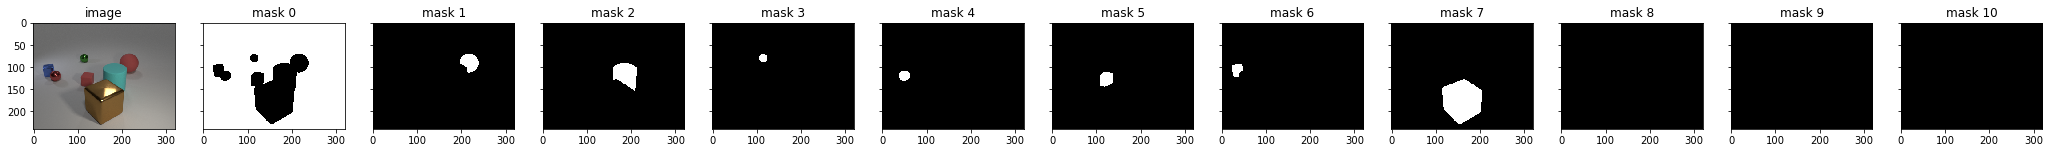

,visibility,x,y,z,pixel_coords,rotation,size,material,shape,color
0,True,0.000000,0.000000,0.00,"[0.0, 0.0, 0.0]",0.000000,0,0,0,0
1,True,0.754801,1.772223,0.70,"[216.0, 92.0, 11.397213]",206.875702,1,1,1,1
2,True,1.661774,-0.613287,0.70,"[184.0, 127.0, 9.417616]",158.639435,1,1,2,2
3,True,-2.911913,0.350314,0.35,"[116.0, 81.0, 13.153035]",330.728607,2,2,1,3
4,True,-1.656102,-2.893203,0.35,"[51.0, 121.0, 10.446547]",31.304531,2,2,1,1
5,True,0.173713,-1.555864,0.35,"[123.0, 129.0, 10.018262]",198.590927,2,1,3,1
6,True,-2.688302,-2.886445,0.35,"[36.0, 109.0, 11.129423]",2.679236,2,2,3,4
7,True,2.826279,-2.497490,0.70,"[160.0, 176.0, 7.5592537]",243.398407,1,2,3,5
8,False,0.000000,0.000000,0.00,"[0.0, 0.0, 0.0]",0.000000,0,0,0,0
9,False,0.000000,0.000000,0.00,"[0.0, 0.0, 0.0]",0.000000,0,0,0,0


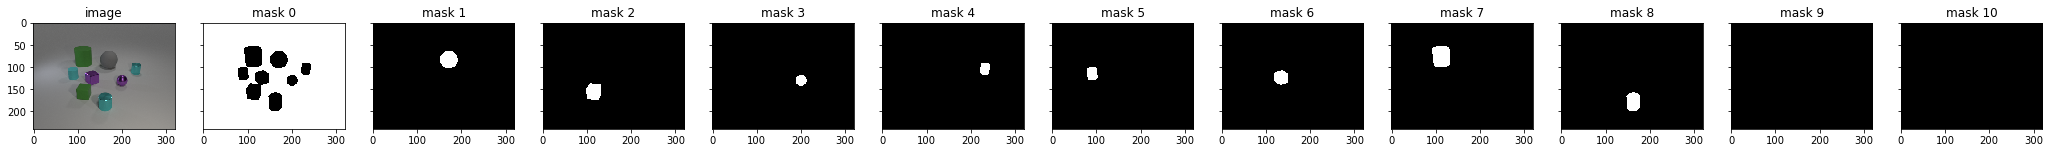

,visibility,x,y,z,pixel_coords,rotation,size,material,shape,color
0,True,0.000000,0.000000,0.00,"[0.0, 0.0, 0.0]",0.000000,0,0,0,0
1,True,-0.724083,1.197578,0.70,"[171.0, 84.0, 12.332107]",52.496296,1,1,1,6
2,True,1.126914,-2.611941,0.35,"[115.0, 156.0, 9.025539]",65.066368,2,1,3,3
3,True,1.768945,-0.029829,0.35,"[201.0, 131.0, 10.152064]",159.788727,2,2,1,7
4,True,1.307390,2.065896,0.35,"[232.0, 105.0, 11.702175]",251.072861,2,2,2,2
5,True,-1.215809,-1.831541,0.35,"[91.0, 115.0, 11.007335]",73.798042,2,1,2,2
6,True,0.161484,-1.231292,0.35,"[133.0, 125.0, 10.47465]",163.282242,2,2,3,7
7,True,-2.693426,0.126708,0.70,"[113.0, 77.0, 12.96682]",252.360382,1,1,2,3
8,True,2.655653,-2.365728,0.35,"[163.0, 179.0, 8.183452]",287.431030,2,2,2,2
9,False,0.000000,0.000000,0.00,"[0.0, 0.0, 0.0]",0.000000,0,0,0,0


In [2]:
def show_sample(sample):
    fig, axs = plt.subplots(
        1,
        1 + sample["mask"].shape[0],
        figsize=np.array([3, 2]) * np.array([1 + sample["mask"].shape[0], 1]),
        sharex=True,
        sharey=True,
    )

    axs[0].imshow(sample["image"], interpolation="none")
    axs[0].set_title("image")

    for m in range(sample["mask"].shape[0]):
        axs[m + 1].imshow(sample["mask"][m], cmap="gray", interpolation="none")
        axs[m + 1].set_title(f"mask {m}")

    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)

    display(
        pd.DataFrame(
            {
                "visibility": sample["visibility"],
                "x": sample["x"],
                "y": sample["y"],
                "z": sample["z"],
                "pixel_coords": list(sample["pixel_coords"]),
                "rotation": sample["rotation"],
                "size": sample["size"],
                "material": sample["material"],
                "shape": sample["shape"],
                "color": sample["color"],
            }
        )
    )


def fix_tf_dtypes(sample):
    sample["mask"] = tf.cast(tf.squeeze(sample["mask"], -1), tf.bool)
    sample["visibility"] = tf.cast(sample["visibility"], tf.bool)
    return sample


ds = multi_object_datasets.clevr_with_masks.dataset(tfr_path.as_posix())
ds = ds.map(fix_tf_dtypes)
ds = ds.take(2)
ds = ds.as_numpy_iterator()

for sample in ds:
    show_sample(sample)

In [3]:
ds = multi_object_datasets.clevr_with_masks.dataset(
    tfr_path.as_posix(), map_parallel_calls=num_cpus
)
ds = ds.map(fix_tf_dtypes)
ds = ds.batch(batch_size)
ds = ds.as_numpy_iterator()

with h5py.File(h5_path, "w") as h5_file:
    for batch in tqdm.tqdm(
        ds, desc="clevr_with_masks", unit=" samples", unit_scale=batch_size
    ):
        for k in batch.keys():
            if k not in h5_file:
                h5_file.create_dataset(
                    k,
                    data=batch[k],
                    shape=batch[k].shape,
                    maxshape=(None, *batch[k].shape[1:]),
                    chunks=True,
                    compression="lzf",
                    # compression="gzip",
                    # compression_opts=9,
                )
            else:
                h5_file[k].resize(h5_file[k].shape[0] + batch[k].shape[0], axis=0)
                h5_file[k][-batch[k].shape[0] :] = batch[k]

with h5py.File(h5_path, "r") as h5_file:
    for k in h5_file.keys():
        print(f"{k:<15} {str(h5_file[k].dtype):<10} {h5_file[k].shape}")

clevr_with_masks: 100000 samples [21:07, 78.90 samples/s] 


color           uint8      (100000, 11)
image           uint8      (100000, 240, 320, 3)
mask            bool       (100000, 11, 240, 320)
material        uint8      (100000, 11)
pixel_coords    float32    (100000, 11, 3)
rotation        float32    (100000, 11)
shape           uint8      (100000, 11)
size            uint8      (100000, 11)
visibility      bool       (100000, 11)
x               float32    (100000, 11)
y               float32    (100000, 11)
z               float32    (100000, 11)
